In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-11 21:52:37--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.1s    

2024-07-11 21:52:38 (1.74 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
with open('names.txt') as f:
    names = f.readlines()
    names = [name.strip('\n') for name in names]

In [5]:
# alternate implementation, used by Andrej
names = open('names.txt', 'r').read().splitlines()

In [6]:
# prepare the vocab
tokens = ['.'] + sorted(set(''.join(names)))
stoi = {}
itos = {}
for i, token in enumerate(tokens):
    stoi[token] = i
    itos[i] = token

In [7]:
context_width = 8
def buildDataset(names):
    X, Y = [], []
    for name in names:
        chars = [0] * context_width
        for x in name + '.':
            xi = stoi[x]
            X.append(chars)
            Y.append(xi)
            chars = chars[1:] + [xi]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return (X, Y)

In [8]:
import random

random.shuffle(names)

n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = buildDataset(names[:n1])
Xval, Yval = buildDataset(names[n1:n2])
Xtest, Ytest = buildDataset(names[n2:])

In [9]:
import random
random.shuffle(names)

samples = len(names)

train = 0.8
val = 0.9
test = 1.0

Xtr, Ytr = buildDataset(names[:int(train*samples)])
Xval, Yval = buildDataset(names[int(train*samples):int(val*samples)])
Xtest, Ytest = buildDataset(names[int(val*samples):])

In [10]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in ** 0.5)
        self.bias = torch.randn((fan_out,)) * 0.1 if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # This is for the offset of the variance in the denominator
        self.momentum = momentum # This is the rate of update of the running mean and variance
        self.training = True # To know which mean and variance to return
        self.bngain = torch.ones(dim) # Gain of the batched variable. To be learnt
        self.bnbias = torch.zeros(dim) # Bias of the batched variable. To be learnt
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)
    def __call__(self, x):
        if self.training:
            # Calculate the batch mean and var
            batch_mean = x.mean(0, keepdims=True)
            batch_var = x.var(0, keepdims=True)
            with torch.no_grad():
                # Update the running mean
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * batch_var
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var
        # Calculate yhat
        self.xhat = (x - batch_mean) / (torch.sqrt(batch_var + self.eps))
        self.yhat = self.bngain * self.xhat + self.bnbias

        return self.yhat

    def parameters(self):
        return [self.bngain, self.bnbias]

class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.weight = torch.randn((vocab_size, n_embd))
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    def parameters(self):
        return [self.weight]
class Flatten:
    def __init__(self, newShape):
        self.newShape = newShape
    def __call__(self, embeddingMatrix):
        self.out = embeddingMatrix.view(self.newShape)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [11]:
vocab_size = len(stoi)
n_embd = 10
hidden_dim = 100

In [12]:
layers = [Embedding(vocab_size, n_embd), Flatten((-1, context_width*n_embd)), Linear(n_embd*context_width, hidden_dim), BatchNorm1d(hidden_dim), Tanh(),
         Linear(hidden_dim, vocab_size)]

model = Sequential(layers)

for p in model.parameters():
    p.requires_grad_()

In [13]:
epochs = 20000
minibatch_size = 64
lr = 0.1
lossi = []
for step in range(epochs):
    # Create minibatch
    minibatch = torch.randint(Xtr.shape[0],(minibatch_size,))

    Xb = Xtr[minibatch]
    Yb = Ytr[minibatch]

    # Forward pass
    logits = model(Xb)

    # Loss
    loss = F.cross_entropy(logits, Yb)
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # Update weights
    for p in model.parameters():
        p.data -= lr * p.grad

    # Statistics
    lossi.append(loss.item())
    if step % 2000 == 0:
        print(f'{step}/{epochs} - loss = {loss.item()}')

0/20000 - loss = 3.4358041286468506
2000/20000 - loss = 2.3353030681610107
4000/20000 - loss = 2.356940746307373
6000/20000 - loss = 2.3424558639526367
8000/20000 - loss = 2.3138513565063477
10000/20000 - loss = 2.487203359603882
12000/20000 - loss = 1.9962165355682373
14000/20000 - loss = 2.1386711597442627
16000/20000 - loss = 2.354161500930786
18000/20000 - loss = 2.020900249481201


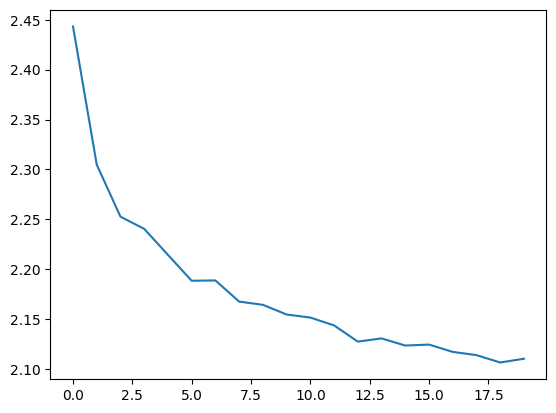

In [14]:
window_size = 1000
plt.plot(torch.tensor(lossi[:20000]).view(-1, window_size).mean(1))

Now let us start to implement WaveNet

In [ ]:
wavenetLayers = [
    Embedding(vocab_size, n_embd),
    Flatten((-1, context_width // 2, 2*n_embd)),
    Linear(2*n_embd, hidden_dim),
    BatchNorm1d(hidden_dim),
    Tanh(),
    Flatten((-1, hidden_dim // 4, 4*n_embd)),
    Linear(4*n_embd, hidden_dim),
    BatchNorm1d(hidden_dim),
    Tanh(),
    Flatten((-1, hidden_dim // 8, 8*n_embd)),
    Linear(8*n_embd, hidden_dim),
    BatchNorm1d(hidden_dim),
    Tanh(),
    Linear(hidden_dim, vocab_size)
]
wavenet = Sequential(wavenetLayers)

In [ ]:
p = sum([param.nelement() for param in wavenet.parameters()])
p

6897

In [ ]:
wavenetLayers[-1].weight.shape

torch.Size([100, 27])

In [ ]:
epochs = 20000
minibatch_size = 64
lr = 0.1
lossi = []
for step in range(epochs):
    # Create minibatch
    minibatch = torch.randint(Xtr.shape[0],(minibatch_size,))

    Xb = Xtr[minibatch]
    Yb = Ytr[minibatch]

    # Forward pass
    logits = wavenet(Xb)

    # Loss
    loss = F.cross_entropy(logits, Yb)
    for p in wavenet.parameters():
        p.grad = None
    loss.backward()

    # Update weights
    for p in wavenet.parameters():
        p.data -= lr * p.grad

    # Statistics
    lossi.append(loss.item())
    if step % 2000 == 0:
        print(f'{step}/{epochs} - loss = {loss.item()}')
    break

RuntimeError: shape '[-1, 25, 40]' is invalid for input of size 25600

In [ ]:
x = Xb
for layer in wavenetLayers:
    x = layer(x)
    print(x.shape)

torch.Size([64, 8, 10])
torch.Size([64, 4, 20])
torch.Size([64, 4, 100])
torch.Size([64, 4, 100])
torch.Size([64, 4, 100])
torch.Size([320, 2, 40])
torch.Size([320, 2, 100])
torch.Size([320, 2, 100])
torch.Size([320, 2, 100])
torch.Size([800, 1, 80])
torch.Size([800, 1, 100])
torch.Size([800, 1, 100])
torch.Size([800, 1, 100])
torch.Size([800, 1, 27])
